<a href="https://colab.research.google.com/github/magikarp01/NumpyCNN/blob/main/CNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import pdb

# example of loading the mnist dataset
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

Classifying the MNist Handwritten Numbers Dataset

11501568/11490434 [==============================] - 0s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


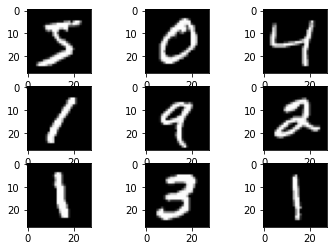

In [2]:
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
trainX = np.divide(trainX, 256)
testX = np.divide(testX, 256)
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	# print(trainX[i])
	plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

# print(trainX[0])

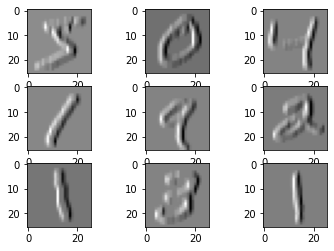

In [3]:
# array2 is smaller, convolutional 
def convolve2d(array1, array2):
  shape1 = array1.shape
  shape2 = array2.shape
  x_size = shape1[0] - shape2[0] + 1
  y_size = shape1[1] - shape2[1] + 1
  fin_array = np.empty((x_size, y_size))
  # print(shape1)
  # print(shape2)
  # print(array1)
  # print(array2)
  for x in range(x_size):
    for y in range(y_size):
      mat1 = array1[x:x+shape2[0], y:y+shape2[1]]
      fin_array[x, y] = np.sum(mat1 * array2)
  return fin_array

vert_convolution = np.array([[-1, 1, 0], [-1, 1, 0], [-1, 1, 0]])
# plot first few images
for i in range(9):
	# define subplot
  plt.subplot(330 + 1 + i)
	# plot raw pixel data
  convolved_image = convolve2d(trainX[i], vert_convolution)
  plt.imshow(convolved_image, cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [4]:
def relu(x):
  return np.maximum(0, x)

def relu_deriv(x):
  if x<0:
    return 0
  return 1

The Convolutional Layer Class, with forward and initialization and 3d convolution methods

In [5]:
# A class for a convolutional layer
class ConvLayer:
  def __init__(self, F=1, kernel_size = (3, 3, 1), same_padding = True):
    self.kernels = np.random.normal(size=(F, kernel_size[0], kernel_size[1], kernel_size[2]))
    self.same_padding = True
    self.F = F
    self.kernel_size = kernel_size
  
  def get_kernels(self):
    return self.kernels

  # array2 is smaller, filter
  # 3d is not actually needed, since z dimension of two arrays are always the same
  def convolve3d(self, array1, array2):
    shape1 = array1.shape
    shape2 = array2.shape
    x_size = shape1[0] - shape2[0] + 1
    y_size = shape1[1] - shape2[1] + 1
    z_size = shape1[2] - shape2[2] + 1
    fin_array = np.empty((x_size, y_size, z_size))
    for x in range(x_size):
      for y in range(y_size):
        for z in range(z_size):
          mat1 = array1[x:x+shape2[0], y:y+shape2[1], z:z+shape2[2]]
          fin_array[x, y, z] = np.sum(mat1 * array2)
    return fin_array

  def forward(self, feature_map):
    # will swap axes, want to iterate by F
    # don't need a feature_map.shape[2] dimension because the output of convolve3d will always have a 3rd dimension of 1
    return_map = np.empty((self.F, feature_map.shape[0], feature_map.shape[1]))

    pad_lengths = [(int(math.ceil((i-1)/2)), int(math.floor((i-1)/2))) for i in self.kernel_size]
    
    for i in range(self.F):
      if self.same_padding:
        array1 = np.pad(feature_map, pad_lengths)
      else:
        array1 = feature_map
      filter = self.kernels[i]
      # print(f'array1: {array1.shape}')
      # print(f'filter: {filter.shape}')
      return_map[i] = np.squeeze(self.convolve3d(array1, filter), 2)
    
    return_map = np.swapaxes(np.swapaxes(return_map, 0, 1), 1, 2)

    return return_map

  # for a refresher, use https://pavisj.medium.com/convolutions-and-backpropagations-46026a8f5d2c
  def backward(self, feature_map, prev_grad, learning_rate):
    # convolve prev_grad and feature_map, prev_grad is filter
    pad_lengths = [(int(math.ceil((i-1)/2)), int(math.floor((i-1)/2))) for i in self.kernel_size]

    if self.same_padding:
      array1 = np.pad(feature_map, pad_lengths)
    else:
      array1 = feature_map

    kernel_gradient = self.convolve3d(array1, prev_grad)
    self.kernels -= learning_rate * kernel_gradient

    # calculate new_prev_grad to backpropagate
    # flip over all axes (basically rotate by 180 degrees) 
    flipped_filter = np.flip(self.kernels)
    
    # have to pad in reverse
    if self.same_padding:
      padded_prev_grad = np.pad(prev_grad, np.flip(pad_lengths))
    else: # "full" convolution, pad by i-1 on both sides of gradient for i in kernel_size
      padded_prev_grad = np.pad(prev_grad, [(i-1, i-1) for i in self.kernel_size])
    
    new_prev_grad = self.convolve3d(padded_prev_grad, flipped_filter)
    return new_prev_grad


For testing ConvLayer

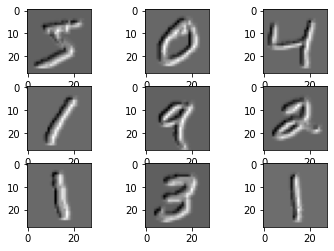

In [6]:
test_convLayer = ConvLayer()
# print(test_convLayer.get_kernels())

for i in range(9):
  train_img = np.expand_dims(trainX[i], axis=2)
  # print(train_img.shape)

  forward_img = np.squeeze(test_convLayer.forward(train_img), 2)
  # print(forward_img)
	# define subplot
  plt.subplot(330 + 1 + i)
	# plot raw pixel data
  plt.imshow(forward_img, cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

In [7]:
# activation layer

def relu(x):
  return np.maximum(0, x)

def relu_deriv(x):
  if x<0:
    return 0
  return 1

class ActivationLayer:
  def __init__(self, activ_func = relu, activ_func_deriv = relu_deriv):
    self.activ_func = activ_func
    self.activ_fun_deriv = activ_func_deriv

  def forward(self, x):
    return self.activ_func(x)
  
  def backward(self, x, prev_deriv, learning_rate):
    return self.activ_fun_deriv(x) * prev_deriv

The Pooling Layer, for now just max pooling

In [8]:
from numpy import unravel_index

class PoolingLayer:
  # size is pool size
  # stride is amount that is skipped between starts of pools
  def __init__(self, size=(2,2), stride=(2,2)):
    self.size = size
    self.stride = stride

  # feature_map is nxnxF, F is number of filters
  def forward(self, feature_map):
    x_size = int((feature_map.shape[0] - self.size[0])/self.stride[0]+1)
    y_size = int((feature_map.shape[1] - self.size[1])/self.stride[1]+1)
    return_map = np.empty((x_size, y_size, feature_map.shape[2]))
    
    cur_x = 0
    cur_y = 0
    for f in range(feature_map.shape[2]):
      for iter_x in range(x_size):
        for iter_y in range(y_size):
          cur_x = iter_x * self.stride[0]
          cur_y = iter_y * self.stride[1]
          pool = feature_map[cur_x:cur_x+self.size[0], cur_y:cur_y+self.size[1], f]
          # print(pool)
          return_map[iter_x, iter_y, f] = np.amax(pool)
          # print(np.amax(pool))
          # cur_x += self.stride[0]
          # cur_y += self.stride[1]
          # iter_x += 1
          # iter_y += 1
          # if cur_x >= feature_map.shape[0] or cur_y >= feature_map.shape[1]:
          #   break

    return return_map


  # prev grad is gradient for each pixel of the pooled layer, size of mxm
  # feature_map is original input into layer
  # want to return the backpropogated gradient, with only the max pixels having a change
  # every non-max pixel doesn't get changed, change of 0
  # basically "stretches out" prev_grad
  def backward(self, feature_map, prev_grad, learning_rate):
    x_size = prev_grad.shape[0]
    y_size = prev_grad.shape[1]

    cur_x = 0
    cur_y = 0

    new_prev_grad = np.zeros_like(feature_map)

    for f in range(feature_map.shape[2]):
      for iter_x in range(x_size):
        for iter_y in range(y_size):
          cur_x = iter_x * self.stride[0]
          cur_y = iter_y * self.stride[1]
          pool = feature_map[cur_x:cur_x+self.size[0], cur_y:cur_y+self.size[1], f]

          # get indices of maximum element in pool
          max_indices = unravel_index(pool.argmax(), pool.shape)

          new_prev_grad[max_indices[0] + cur_x, max_indices[1] + cur_y, f] = prev_grad[iter_x, iter_y, f]

    return new_prev_grad

For testing pooling

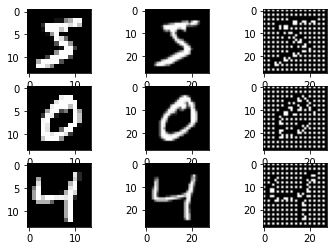

In [9]:
test_poolLayer = PoolingLayer()
# print(test_convLayer.get_kernels())

for i in range(3):
  train_img = np.expand_dims(trainX[i], axis=2)
  # print(train_img.shape)

  forward_img = np.squeeze(test_poolLayer.forward(train_img), 2)
  # print(forward_img.shape)
  test_grad = np.ones((14, 14, 1))
  backward_img = np.squeeze(test_poolLayer.backward(train_img, test_grad, .01), 2)
  # print(forward_img)
	# define subplot
  # plt.subplot(330 + 1 + i)
	# plot raw pixel data


  plt.subplot(331+3*i)
  plt.imshow(forward_img, cmap=plt.get_cmap('gray'))
  
  plt.subplot(332 + 3*i)
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))

  plt.subplot(333 + 3*i)
  plt.imshow(backward_img, cmap=plt.get_cmap('gray'))

# show the figure
plt.show()

In [10]:
# flattening layer for flattening the pooled nxnxf into 1x(n^2*f) layer

class FlatteningLayer:
  def __init__(self):
    return

  # feature map is nxnxf
  def forward(self, feature_map):
    tot_size = feature_map.size
    return_map = np.empty((1, tot_size))
    iter = 0
    for x in range(feature_map.shape[0]):
      for y in range(feature_map.shape[1]):
        for z in range(feature_map.shape[2]):
          return_map[0, iter] = feature_map[x, y, z]
          iter += 1
    return return_map

  # accept 1x(n^2*f) prev_grad and return nxnxf gradient
  def backward(self, feature_map, prev_grad, learning_rate):
    new_prev_grad = np.empty_like(feature_map)
    iter = 0
    for x in range(feature_map.shape[0]):
      for y in range(feature_map.shape[1]):
        for z in range(feature_map.shape[2]):
          new_prev_grad[x, y, z] = prev_grad[0, iter]
          iter += 1

    return new_prev_grad

In [11]:
# for testing flattening

test_flatLayer = FlatteningLayer()
test_feature_map = np.random.rand(2, 3, 4)
print(test_feature_map)
print(test_feature_map.shape)

flattened_layer = test_flatLayer.forward(test_feature_map)
print(flattened_layer)
print(flattened_layer.shape)

unflattened_layer = test_flatLayer.backward(test_feature_map, flattened_layer, .01)
print(unflattened_layer)
print(unflattened_layer.shape)

[[[0.25273322 0.29024663 0.21067403 0.55444118]
  [0.30616693 0.31522414 0.58511613 0.43578149]
  [0.47397244 0.90077986 0.89102368 0.49777146]]

 [[0.09768218 0.7151823  0.48253396 0.01290049]
  [0.74955225 0.25264952 0.56784272 0.74807238]
  [0.03651584 0.60590505 0.22473213 0.56998716]]]
(2, 3, 4)
[[0.25273322 0.29024663 0.21067403 0.55444118 0.30616693 0.31522414
  0.58511613 0.43578149 0.47397244 0.90077986 0.89102368 0.49777146
  0.09768218 0.7151823  0.48253396 0.01290049 0.74955225 0.25264952
  0.56784272 0.74807238 0.03651584 0.60590505 0.22473213 0.56998716]]
(1, 24)
[[[0.25273322 0.29024663 0.21067403 0.55444118]
  [0.30616693 0.31522414 0.58511613 0.43578149]
  [0.47397244 0.90077986 0.89102368 0.49777146]]

 [[0.09768218 0.7151823  0.48253396 0.01290049]
  [0.74955225 0.25264952 0.56784272 0.74807238]
  [0.03651584 0.60590505 0.22473213 0.56998716]]]
(2, 3, 4)


In [12]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

# ignoring chain rule
def sigmoid_deriv(x):
  return sigmoid(x) * (1 - sigmoid(x))

In [13]:
class FullyConnectedLayer:
  # num_inputs is m
  # num_neurons is n
  def __init__(self, num_inputs, num_neurons, activation_func=sigmoid, activation_func_deriv=sigmoid_deriv):
    self.weights = np.random.normal(size = (num_inputs, num_neurons))
    self.biases = np.random.normal(size=(1, num_neurons))
    self.activation_func = activation_func
    self.activation_func_deriv = activation_func_deriv


  # x is 1xm
  # weights is mxn
  # bias is 1xn
  def forward(self, x):
    # print(x.shape)
    # print(self.weights.shape)
    # print(self.biases.shape)
    return self.activation_func(x @ self.weights + self.biases)

  def get_weights(self):
    return self.weights
  
  def get_biases(self):
    return self.biases

  # x is input from previous layer, mx1 matrix for m different neurons in prev layer
  # for layer 3, need gradient of loss w.r.t. activation of layer 3 as prev_grad
  # prev_grad is 1xn gradient for n neurons 
  def backward(self, x, prev_grad, learning_rate):
    # print("for common factor:")
    # print(prev_grad.shape)
    # print(self.weights.shape)
    # print(self.biases.shape)

    common_factor = prev_grad * self.activation_func_deriv(x @ self.weights + self.biases) # both 1 x n matrix

    # print("for weight gradient:")
    # print(x.shape)
    # print(common_factor.shape)

    weight_gradient = np.transpose(x) @ common_factor # (mx1) @ (1xn) returns mxn matrix
    bias_gradient = common_factor 

    self.weights -= learning_rate * weight_gradient
    self.biases -= learning_rate * bias_gradient
    
    # returns gradient of loss w.r.t. x (activation of previous layer)
    activ_gradient = common_factor @ np.transpose(self.weights)
    return activ_gradient

Testing Fully Connected Layer by making an ML for calculating AND

In [ ]:
# train_x = np.random.random_integers(low=0, high=1, size=(10000, 2))
# train_x = np.random.normal(size=(10000, 2))
train_x = np.random.rand(10000, 2)

# train_y = train_x[:,0] & train_x[:,1]
train_y = np.sin(train_x[:,0]) * np.cos(train_x[:,1])
# train_y = train_x[:,0] * train_x[:,1]
for i in train_y:
  if i<0 or i>1:
    print("OUTSIDE RANGE")

train_y = np.expand_dims(train_y, 1)
train_x = np.expand_dims(train_x, 1)

class SimpleNeuralNet:
  # input size is number of inputs into first layer
  def __init__(self, num_layers=2, layer_sizes=(10, 1), input_size = 2):
    self.layers = []
    self.num_layers = num_layers
    prev_layer_neurons = input_size
    for i in range(num_layers):  
      self.layers.append(FullyConnectedLayer(num_inputs=prev_layer_neurons, num_neurons = layer_sizes[i]))
      prev_layer_neurons = layer_sizes[i]
      # print(self.layers[i].get_weights().shape)
    

  def forward(self, x):
    new_x = x
    for i in range(self.num_layers):
      new_x = self.layers[i].forward(new_x)
    return new_x
  

  # prev_grad is gradient of loss w.r.t last layer
  def backward(self, x, prev_grad, learning_rate):
    activations = []
    new_x = x
    for i in range(self.num_layers):
      new_x = self.layers[i].forward(new_x)
      activations.append(new_x)
    # when accessing the -1th activation, should be the starting input
    activations.append(x)

    new_prev_grad = prev_grad
    for i in range(self.num_layers-1, -1, -1):
      # print(i)
      new_prev_grad = self.layers[i].backward(x=activations[i-1], prev_grad=new_prev_grad, learning_rate=learning_rate)
    
  
my_neural_net = SimpleNeuralNet(num_layers=2, layer_sizes=(10,1), input_size=2)
pred_y = my_neural_net.forward(train_x[0])
# print(pred_y)

def loss(output, y):
  return np.sum((output - y)**2)/y.shape[0]

def loss_deriv(output, y):
  return 2 * (output - y)

# print(pred_y)
# print(train_y)
# loss(pred_y, train_y)

for epoch in range(10):
  total_loss = 0
  for (x, y) in zip(train_x, train_y):
    output = my_neural_net.forward(x)
    curr_loss = loss(output, y)
    total_loss += curr_loss
    learning_rate = .02

    my_neural_net.backward(x=x, prev_grad=loss_deriv(output, y), learning_rate=learning_rate)
  
  print(total_loss)

  import random
  first_num = random.random()
  second_num = random.random()
  print(f"test: {np.sin(first_num)}, {np.cos(second_num)} = {np.sin(first_num) * np.cos(second_num)}, "
  + f"neural network predicts {my_neural_net.forward(np.array([first_num, second_num]))}")

In [ ]:
def softmax(x):
  

Testing the full Convolutional Neural Network


In [ ]:
def loss(output, y):
  return np.sum((output - y)**2)


layers = [ConvLayer(F=32, kernel_size=(3,3,1), same_padding=True),
          ActivationLayer(activ_func=relu, activ_func_deriv=relu_deriv),
          PoolingLayer(size=(2,2), stride=(2,2)),
          FlatteningLayer(),
          FullyConnectedLayer(num_inputs=196, num_neurons=20, activation_func=sigmoid, activation_func_deriv=sigmoid_deriv),
          FullyConnectedLayer(num_inputs=20, num_neurons=10, activation_func=sigmoid, activation_func_deriv=sigmoid_deriv)
          ]
